__автоэнкодер__  

Евгений Борисов borisov.e@solarl.ru

сжимаем  картинку MNIST из размера [28x28] в [2]   
и обратно из [2] в [28x28]  



https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/master/3-Neural_Network_Architecture/autoencoder.py

http://www.cs.toronto.edu/~hinton/science.pdf

In [1]:
# import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [3]:
# default GPU device
if tf.test.is_built_with_cuda():
    print([ 
          d.physical_device_desc 
          for d in tf.python.client.device_lib.list_local_devices() 
          if d.device_type == 'GPU' and d.name==tf.test.gpu_device_name()
        ])

['device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1']


## модель

In [4]:
# import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [5]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(128, activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(64 , activation='tanh')
        self.dense_3 = tf.keras.layers.Dense(32 , activation='tanh')
        self.dense_4 = tf.keras.layers.Dense(2  , activation='sigmoid')
    def call(self, x, training=False):
        out = self.dense_1(x)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return out

In [6]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(16 , activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(64 , activation='tanh')
        self.dense_3 = tf.keras.layers.Dense(128, activation='tanh')
        self.dense_4 = tf.keras.layers.Dense(784, activation='sigmoid')
    def call(self, x, training=False):
        out = self.dense_1(x)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return out

In [7]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def call(self, x, training=False):
        out = self.encoder(x, training)
        out = self.decoder(out, training)
        return out

## датасет

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (np.reshape(X_train, (-1, 784)) / 255.).astype(np.float32)
X_test = (np.reshape(X_test, (-1, 784)) / 255.).astype(np.float32)

In [9]:
# примеры для визуальной оценки результата
n_samples = 9
ii = np.random.randint(0,X_test.shape[0], n_samples)
sample = X_test[ii,:]

In [10]:
X_train.shape, sample.shape

((60000, 784), (9, 784))

In [11]:
model = Autoencoder()

In [12]:
%%time 

n_epoch = 15000
batch_size = 512
learning_rate = 1e-4
loss_history = []

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)


def train_step(true_image,optimizer=optimizer):
    
    with tf.GradientTape() as tape:
        pred_image = model(true_image, training=True)
        loss = tf.reduce_mean(tf.square(pred_image-true_image))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    return loss        

CPU times: user 45 µs, sys: 8 µs, total: 53 µs
Wall time: 55.6 µs


=>    0 loss 0.2315
=> 1000 loss 0.0669
=> 2000 loss 0.0676
=> 3000 loss 0.0644
=> 4000 loss 0.0593
=> 5000 loss 0.0561
=> 6000 loss 0.0525
=> 7000 loss 0.0521
=> 8000 loss 0.0488
=> 9000 loss 0.0475
=> 10000 loss 0.0454
=> 11000 loss 0.0433
=> 12000 loss 0.0422
=> 13000 loss 0.0418
=> 14000 loss 0.0432
CPU times: user 7min 15s, sys: 12.1 s, total: 7min 27s
Wall time: 3min 38s


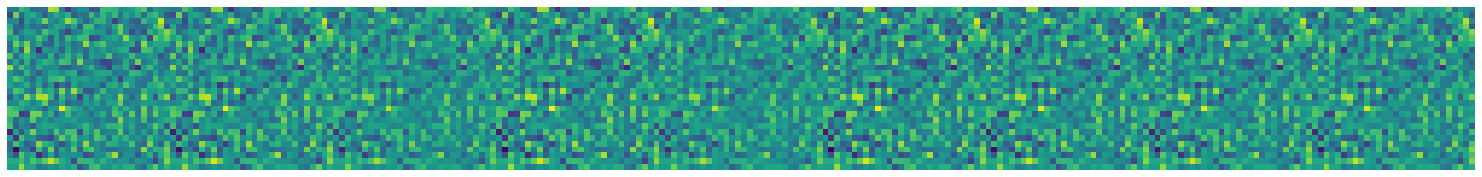

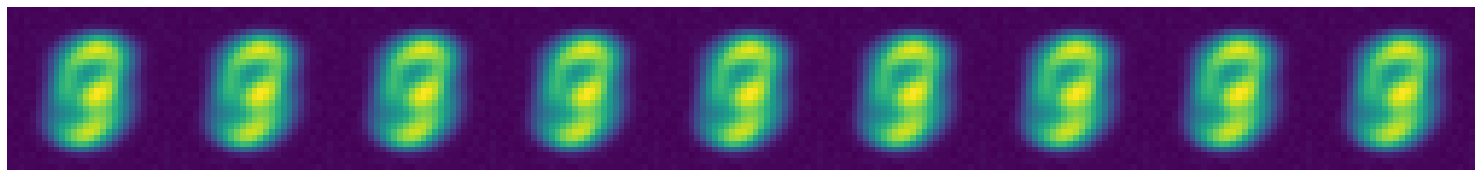

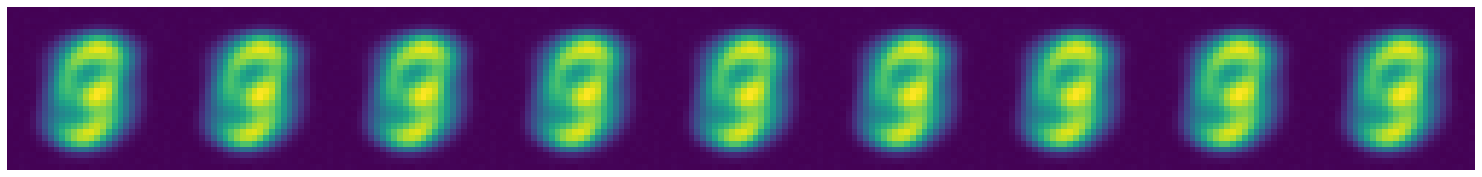

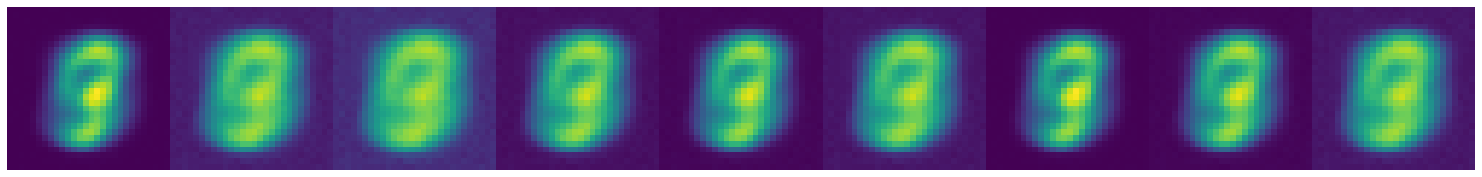

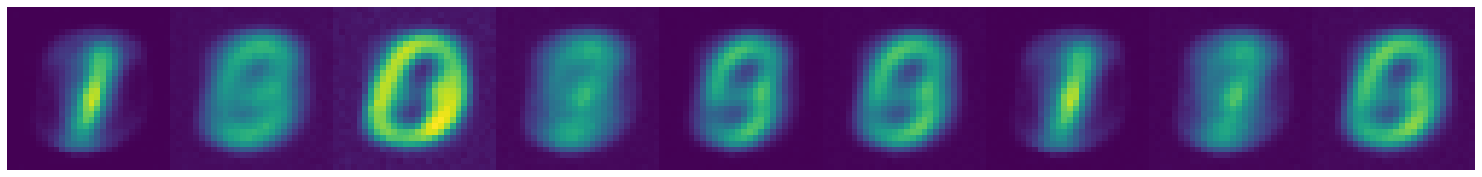

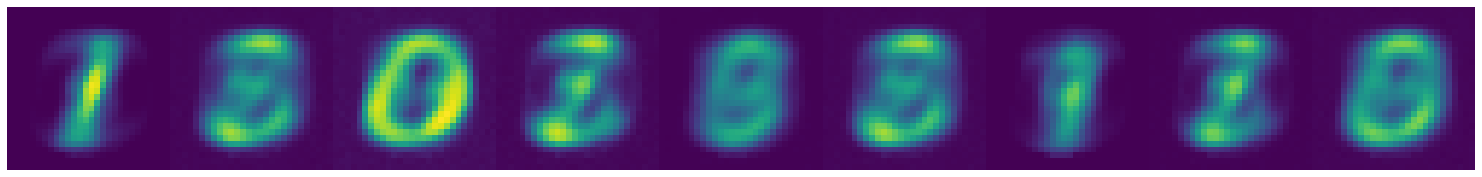

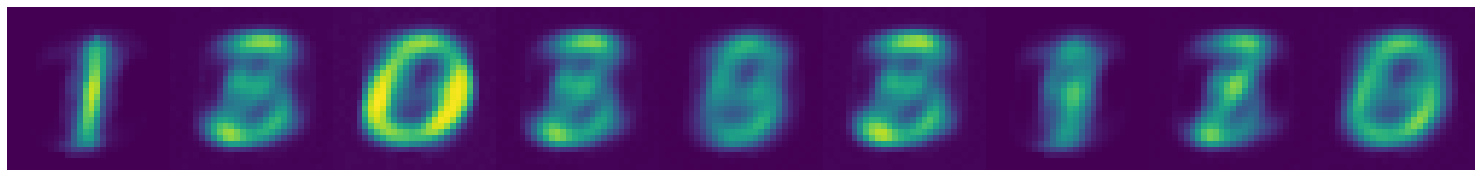

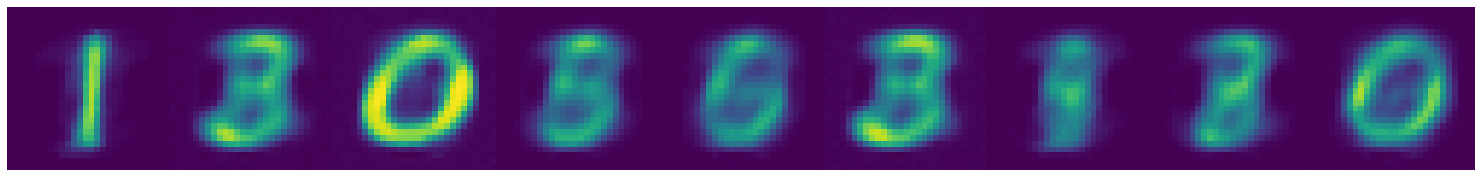

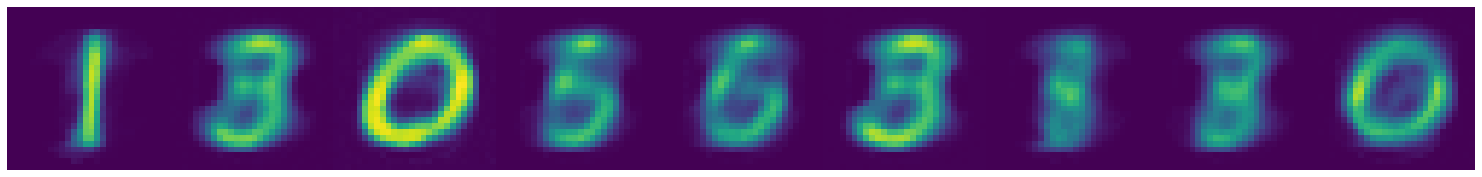

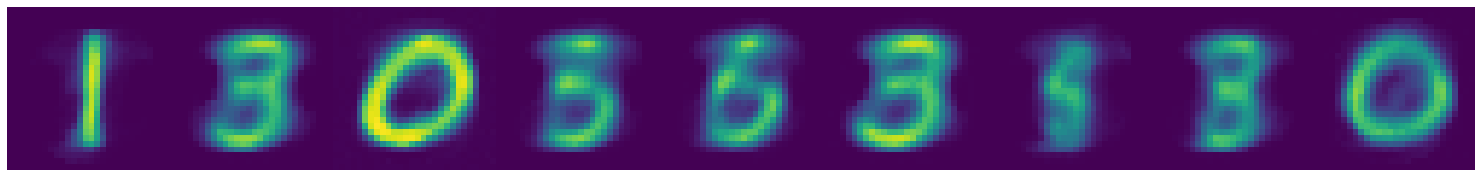

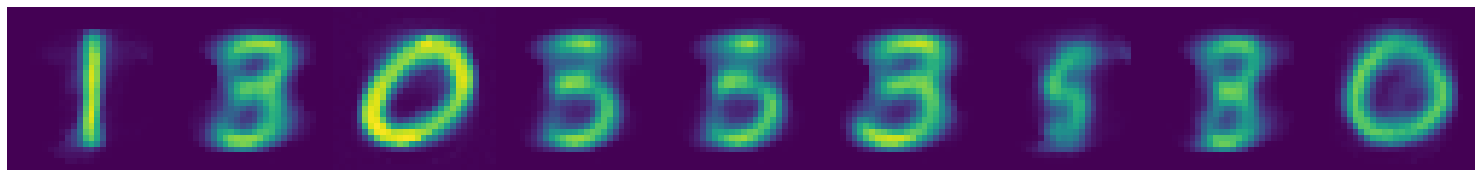

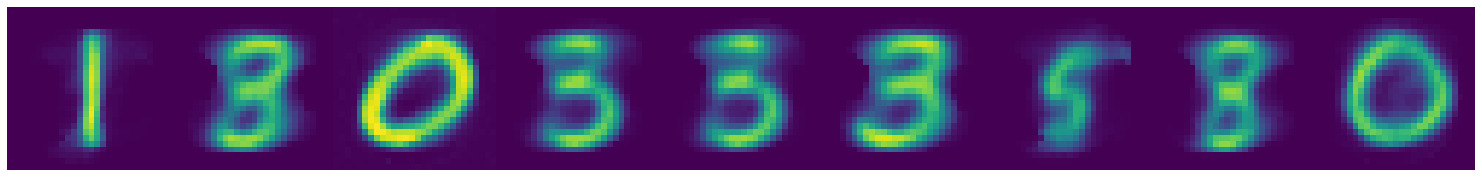

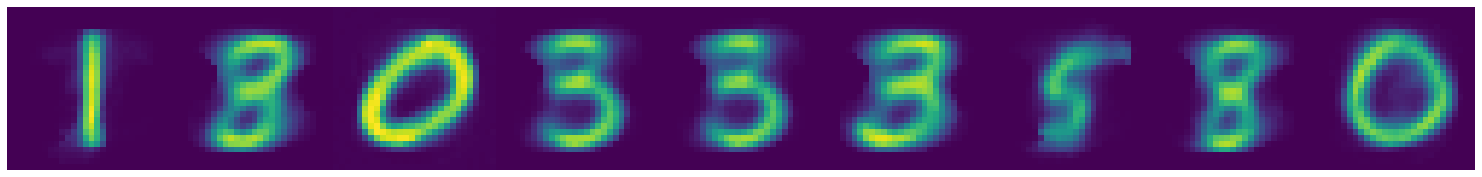

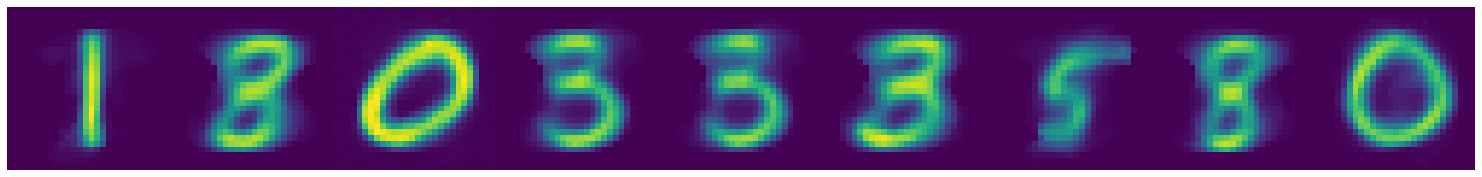

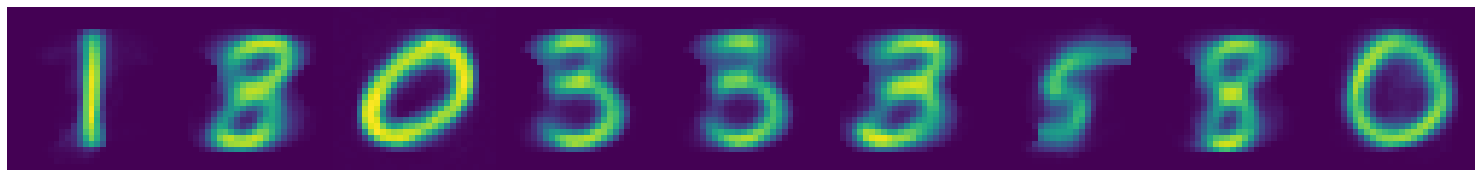

In [13]:
%%time 

for step in range(n_epoch):
    
    true_image = X_train[np.random.choice(X_train.shape[0], batch_size)]
    
    loss = train_step(true_image).numpy()
    
    loss_history.append(loss)
    
    if step % 1000 == 0:
        print("=> %4d loss %.4f" %(step, loss))
        pred_image = model(sample, training=False)
        pred_image = np.reshape(pred_image, (n_samples, 28, 28))
        show_image = np.concatenate(pred_image[:n_samples], -1)
        plt.figure(figsize=(n_samples*3,3))
        plt.axis(False)
        plt.imshow(show_image)
        
#         plt.savefig('aenc/%05d.png'%(step))

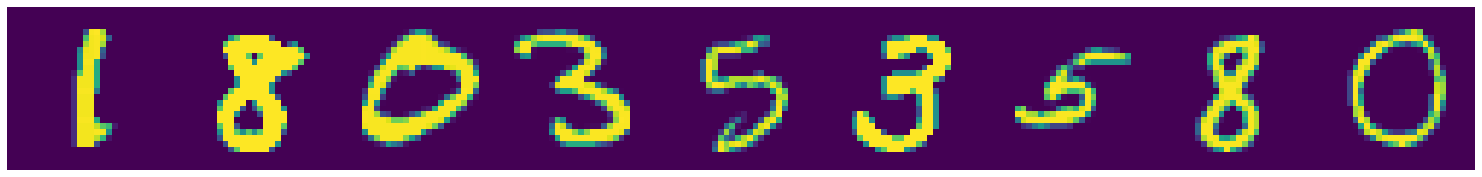

In [14]:
image = np.reshape(sample, (n_samples, 28, 28))
show_image = np.concatenate(image[:n_samples], -1)
plt.figure(figsize=(n_samples*3,3))
plt.axis(False)
plt.imshow(show_image)

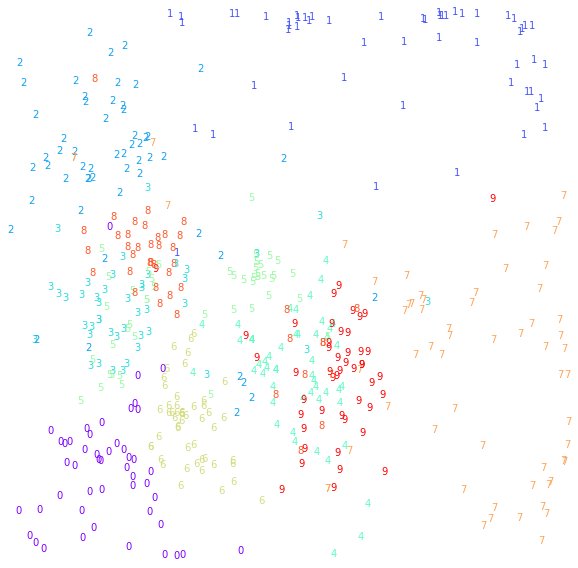

In [15]:
ii = np.random.randint(0,X_test.shape[0], 500)

label = y_test[ii]
embeddings = model.encoder(X_test[ii,:], training=False)

X = embeddings[:,0].numpy()
Y = embeddings[:,1].numpy()

colors = { i:cm.rainbow(int((255*i)/9)) for i in range(10) }

fig,ax = plt.subplots(figsize=(10,10))

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())

for x,y,l in zip(X,Y,label): ax.text(x, y, l, color=colors[l])
    
plt.axis(False)
plt.show()

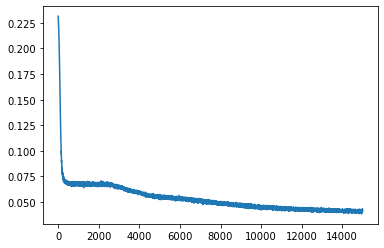

In [16]:
plt.plot(loss_history)